# Задание 1
- Шеверев Сергей Вячеславович
- 22М-05ММ
- Вариант 3


Промоделируем сложно-пуассоновское распределение с внутренним отрицательным биномиальным:
 - Построим полигон частот;
 - Вычислим
  - среднее,
  - медиану,
  - моду,
  - дисперсию,
  - стандартное отклонение,
  - асимметрию,
  - эксцесс.

In [61]:
import numpy as np
from typing import Callable 
import functools
from matplotlib import pyplot as plt
from statistics import mode
import pandas as pd


In [55]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Параметры распределений:
- Внутреннее:
 - **succ_number** - количесво успехов в испытаниях 
 - **succ_prob** - вероятность успеха
- Внешнее: 
 - **lam** - параметр $\lambda$
- **amount_of_bins** - задает количество интервалов группировки при построении полигона частот

In [112]:
succ_number = 5
succ_prob = 0.13
lam = 10

amount_of_bins = 30

### Определим ряд вспомогательных функций:

- ```complex_poisson``` - функция генерации сложно-пуссоновских случайных величин
- ```nbinom``` - фунция генерации случайных величин, распределенных по негативному биномиальному закону
- ```get_moment``` - функция для вычисления $n-го$ момента
- ```skewness``` - функция для вычисления коэффициента асимметрии
- ```kurtosis``` - функция для вычисления эксцесса

In [39]:
def complex_poisson(callee: Callable, lam: float = 1.0, size: int = 1000)->np.ndarray:
    res = np.random.poisson(lam, size)
    return np.array(list(map(sum, map(callee, res))))


def nbinom(size):
    return np.random.negative_binomial(n=succ_number, p=succ_prob, size=size)

def get_moment(data: np.array, mean = None, order: int =1):
    if mean is None:
        mean = data.mean()
    return sum((data - mean)**order)/len(data)

def skewness(data: np.array):
    return get_moment(data, order=3)/(data.std()**3)

def kurtosis(data: np.array):
    return get_moment(data, order=4)/get_moment(data, order=2)**2 -3 


### Построим полигоны частот для выборок разного размера:

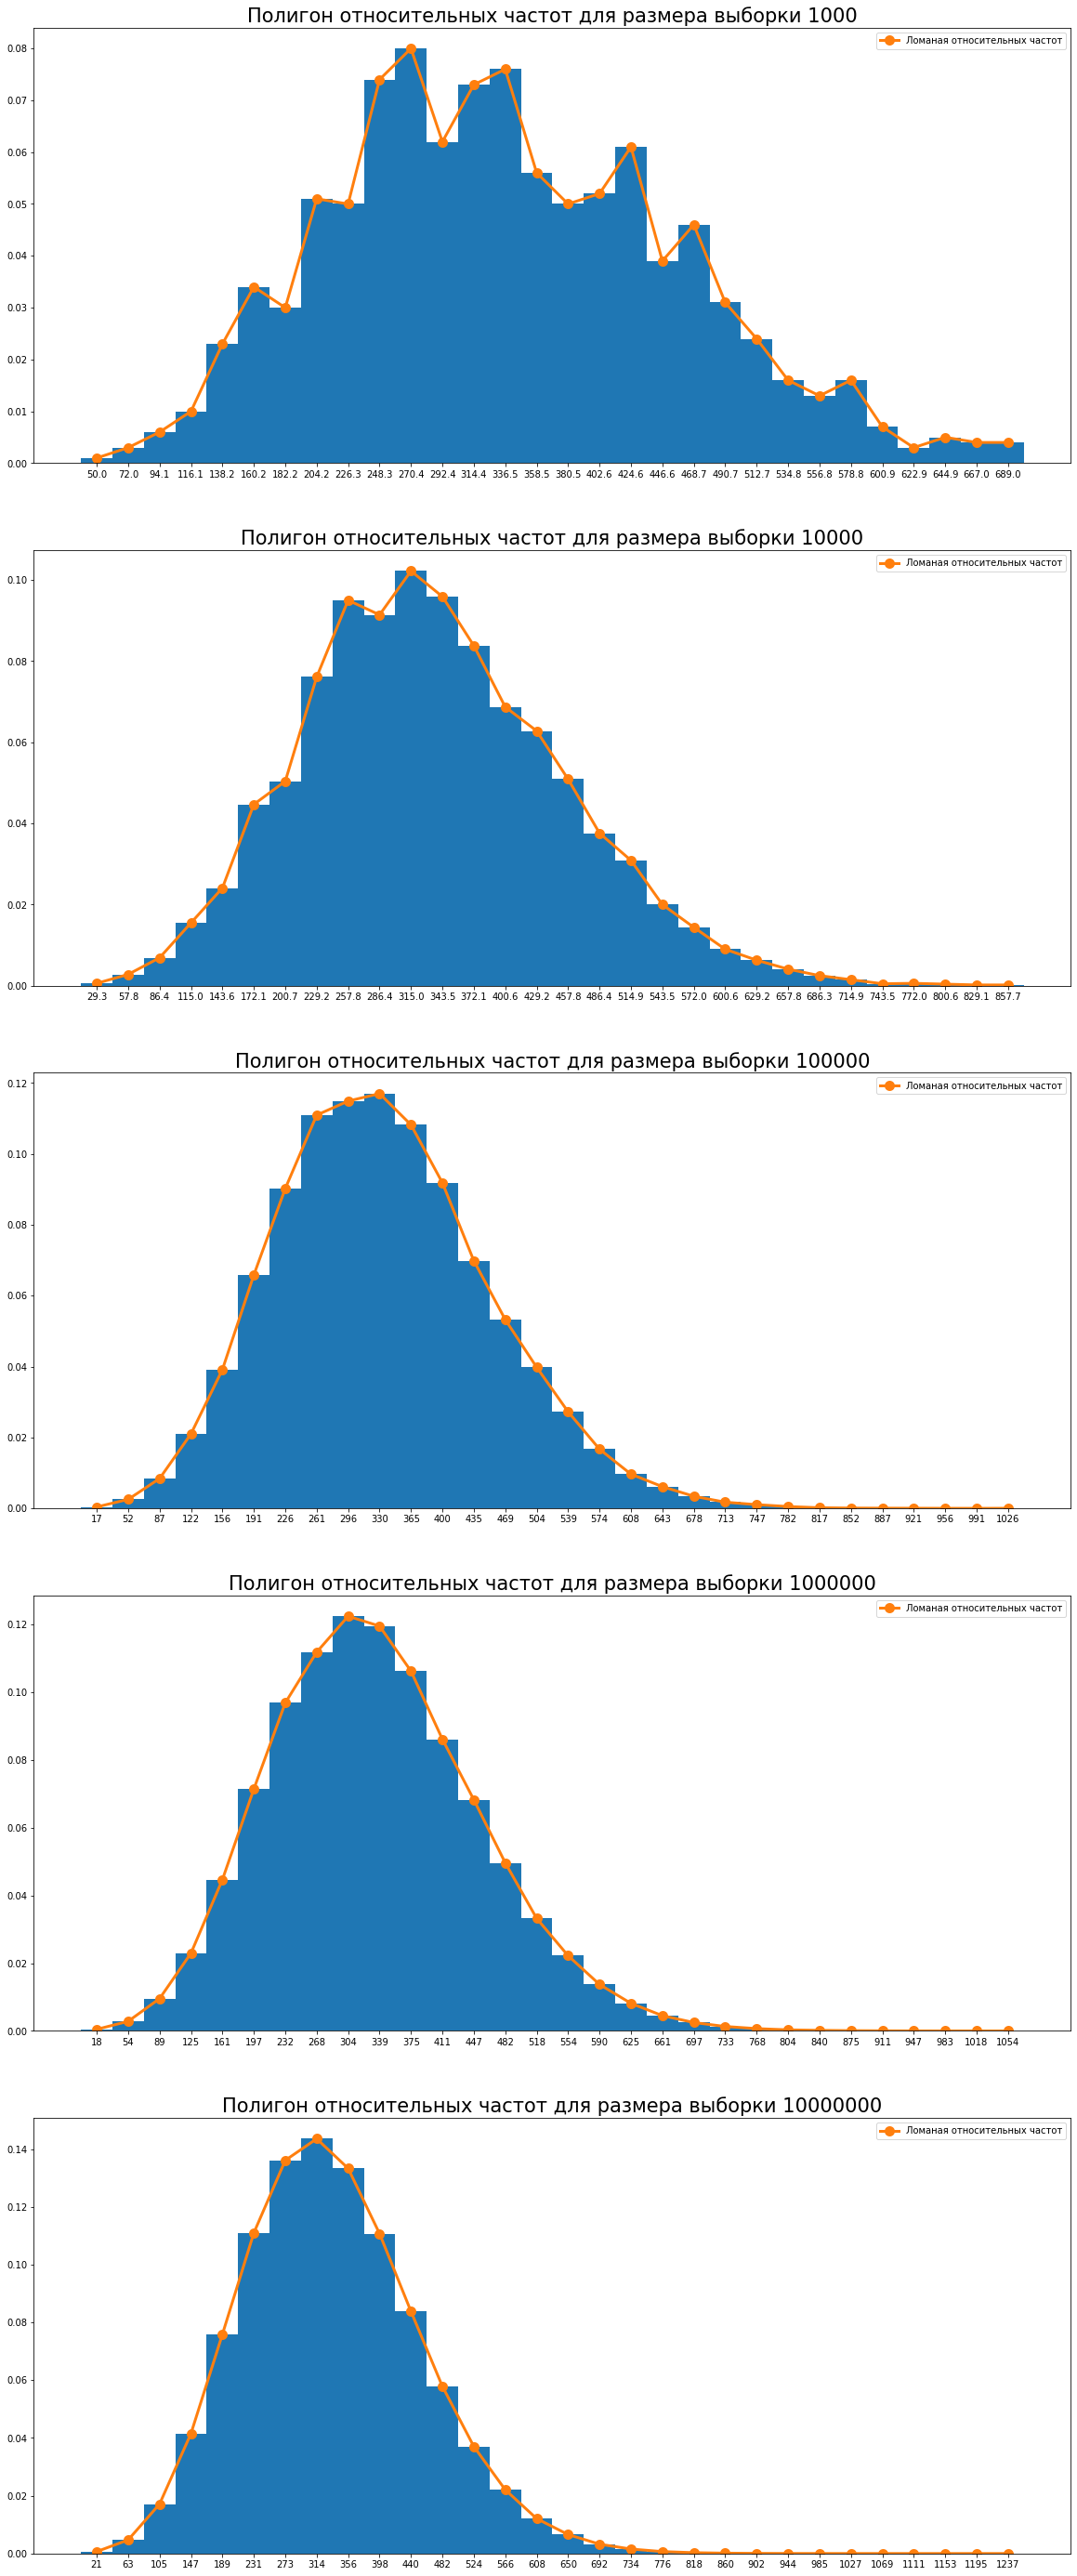

,vector size,mean,std,dispersion,range,mode,skewness,kurtosis
0,1000,336.688000,119.938854,14385.328656,661,426,0.360381,-0.226689
1,10000,335.596800,117.675529,13847.530030,857,267,0.425980,0.206624
2,100000,334.698170,117.411629,13785.490509,1043,326,0.417093,0.183016
3,1000000,334.531645,117.391418,13780.745081,1072,297,0.415529,0.202843
4,10000000,334.635711,117.325904,13765.367674,1258,303,0.413983,0.196263


In [113]:
sizes = [10**i for i in range(3, 8)] 
props = dict()
props['vector size'] = sizes
props['mean'] = []
props['std'] = []
props['dispersion'] = []
props['range'] = []
props['mode'] = []
props['skewness']= []
props['kurtosis']= []


fig = plt.figure()
fig.set_size_inches(20, 10*len(sizes))
for num,size in enumerate(sizes):
    rv_realization = complex_poisson(nbinom, lam, size)
    counts, bins = np.histogram(rv_realization, bins=amount_of_bins)
    counts = np.array(counts, dtype='float64')/len(rv_realization)
    bins_mids = [(i+k)/2 for i, k in zip(bins[:-1], bins[1:])]
    
    plt.subplot(len(sizes), 1, num+1)
    plt.hist(bins[:-1], bins, weights=counts)
    plt.plot(bins_mids, counts, label='Ломаная относительных частот', linewidth=3, marker='o', markeredgewidth=5)
    plt.xticks(bins_mids)
    plt.title(f"Полигон относительных частот для размера выборки {size}", fontsize=21)
    plt.legend()
    
    props['mean'].append(rv_realization.mean())
    props['std'].append(rv_realization.std())
    props['dispersion'].append(props['std'][-1]**2)
    props['range'].append(rv_realization.max() - rv_realization.min())
    #props['mode'].append(mode(rv_realization))
    vals, counts = np.unique(rv_realization, return_counts=True)
    props['mode'].append(vals[np.argmax(counts)])
    props['skewness'].append(skewness(rv_realization))
    props['kurtosis'].append(kurtosis(rv_realization))
plt.show()
df = pd.DataFrame(data=props)
df

В таблице выше вычислены требуемые характеристики выборок, где
- `vector size` есть размер выборки
- `mean` - мат. ожидание выборки
- `std` - стандартное отклонение выборки 
- `dispersion` - дисперсия выборки
- `mode` - мода выборки
- `range` - размах выборки
- `skewness` - коэффициент асимметрии выборки
- `kurtosis` - эксцесс выборки

### Проверим правильность вычислений:

Начальные моменты в случае сложно-пуассоновского распределения удобно считать через производящии функции:
$$ g(t) = \frac{p^k}{(1-qt)^k}$$
$$ h(t) = exp(\lambda(t-1)) $$
где $g(t)$ есть производящая функция внутреннего отрицательного биномиального распределения, а $h(t)$ -- производящая функция распределения Пуассона


Тогда производящая функция целевого распределения примет вид композиции:
$$ h(g(t)) = exp(\lambda (\frac{p^k}{(1-qt)^k} - 1))$$

$$ h(g(t))' = h'(g(t))\cdot g'(t)$$
$$ h(g(t))'' = h''(g(t))\cdot g'(t)^2 + h'(g(t))\cdot g''(t) $$
$$ g'(t) = kqp^k(1-qt)^{-k-1} $$
$$ g''(t) = k (1 + k) p^k q^2 (1 - q t)^{-2 - k}$$
$$ h'(t) = \lambda exp(\lambda (t-1))$$
$$ h''(t) = e^{(-1 + t) \lambda} \lambda^2 $$


Теперь можем посчитать математическое ожидание и дисперсию
- $ E\tau = \phi'(1)$
- $ D\tau = \phi''(1) + \phi'(1) - \phi'(1)^2 $

In [127]:


from math import exp

def pf_nbinom(t):
    q = 1 - succ_prob
    return (succ_prob**succ_number)/((1 - q*t)**succ_number)
def d_pf_nbinom(t):
    q = 1 - succ_prob
    return succ_number*q*(succ_prob**succ_number)*((1-q*t)**(-succ_number - 1))
def d2_pf_nbinom(t):
    q = 1 - succ_prob
    return succ_number*(1 + succ_number)*(succ_prob**succ_number)*(q**2)*((1-q*t)**(-2 - succ_number))

def pf_poisson(t):
    return exp( lam*(t-1) )

def d_pf_poisson(t):
    return lam*exp( lam*(t-1) )

def d2_pf_poisson(t):
    return (lam**2)*exp(lam*(t-1))

def d_pf_complex(t):
    return d_pf_poisson( pf_nbinom(t) ) * d_pf_nbinom(t)

def d2_pf_complex(t):
    return d2_pf_poisson( pf_nbinom(t) ) * ( d_pf_nbinom(t)**2 ) + d_pf_poisson( pf_nbinom(t) )*d2_pf_nbinom(t)

In [126]:
expectation = d_pf_complex(1)
dispersion  = d2_pf_complex(1) + d_pf_complex(1) - (d_pf_complex(1)**2)

In [128]:
print(f'Математическое ожидание: {expectation}\nДисперсия: {dispersion}')

Математическое ожидание: 334.6153846153845
Дисперсия: 13770.7100591716


Вычисленные значения "слабо" отличаются от полученных в ходе моделирования сложно-пуассоновского распределения